The above piece of code performs the following actions:
It constructs a URL for an audio file:
The base URL is "https://people.csail.mit.edu"
The path to the specific audio file is "/mrub/VisualMic/Supplemental/Recorded_Speech/Chips1-2200Hz-TIMIT_fadg0_sa1/input.wav"
These components are concatenated to form the complete audio_url
It uses the os.system() function to execute a shell command:
The command being executed is wget, a popular command-line utility for downloading files from the internet
The -O audio.wav option tells wget to save the downloaded file as "audio.wav" in the current directory
The audio_url is appended to the wget command, specifying the source of the file to be downloaded



In [9]:
import os

audio_url = "https://people.csail.mit.edu" + \
    "/mrub/VisualMic/Supplemental/Recorded_Speech"+ \
    "/Chips1-2200Hz-TIMIT_fadg0_sa1/input.wav"

os.system("wget -O audio.wav " + audio_url)

0

In [10]:
import torch
import torchaudio

In [11]:
waveform, sample_rate = torchaudio.load("audio.wav")

waveform.squeeze_()

tensor([-0.1058, -0.1022, -0.1011,  ..., -0.1022, -0.1015, -0.1017])

In [13]:
####################

PAD        = 0
N_FFT      = 400
WIN_LENGTH = N_FFT
HOP_LENGTH = WIN_LENGTH // 2
WINDOW     = torch.hann_window(WIN_LENGTH)
POWER      = 2.0
NORMALIZED = False
CENTER     = True
PAD_MODE   = "reflect"
ONESIDED   = True

f_spectrogram = lambda x: torchaudio.functional.spectrogram(
    x          ,
    PAD        ,
    WINDOW     ,
    N_FFT      ,
    HOP_LENGTH ,
    WIN_LENGTH ,
    POWER      ,
    NORMALIZED ,
    CENTER     ,
    PAD_MODE   ,
    ONESIDED   )

N_ITER   = 32
MOMENTUM = 0.99
LENGTH   = None
RAND_INT = True

f_griffinLim = lambda x: torchaudio.functional.griffinlim(
    x,
    WINDOW     ,
    N_FFT      ,
    HOP_LENGTH ,
    WIN_LENGTH ,
    POWER      ,
    N_ITER     ,
    MOMENTUM   ,
    LENGTH     ,
    RAND_INT   )

####################

N_MELS      = 64
SAMPLE_RATE = 16000
F_MIN       = 0.0
F_MAX       = float(SAMPLE_RATE // 2)
N_STFT      = N_FFT // 2 + 1
NORM        = None
MEL_SCALE   = "htk"

m_filterbank = torchaudio.functional.melscale_fbanks(
    N_STFT      ,
    F_MIN       ,
    F_MAX       ,
    N_MELS      ,
    SAMPLE_RATE ,
    NORM        ,
    MEL_SCALE   )

f_melScale = lambda x: torch.matmul(x.transpose(-1, -2), m_filterbank).transpose(-1, -2)

N_STFT           = N_FFT
N_MELS           = 64
SAMPLE_RATE      = 16000
F_MIN            = 0.0
F_MAX            = float(SAMPLE_RATE // 2)
MAX_ITER         = 100000
TOLERANCE_LOSS   = 1e-05
TOLERANCE_CHANGE = 1e-08
SGDARGS          = {"lr": 0.1, "momentum": 0.9}
NORM             = None
MEL_SCALE        = 'htk'

f_inv_melScale = lambda x: torchaudio.transforms.InverseMelScale(
    n_stft=N_STFT//2 + 1,
    n_mels=N_MELS,
    sample_rate=SAMPLE_RATE,
    f_min=F_MIN,
    f_max=F_MAX,
    max_iter=MAX_ITER,
    tolerance_loss=TOLERANCE_LOSS,
    tolerance_change=TOLERANCE_CHANGE)(x)


####################

LOG_OFFSET = 1e-6

f_log = lambda x: torch.log(x + LOG_OFFSET)

f_exp = lambda x: torch.exp(x) - LOG_OFFSET

####################

N_MFCC = 26
N_MELS = N_MELS
NORM   = "ortho"

m_dct = torchaudio.functional.create_dct(
    N_MFCC ,
    N_MELS ,
    NORM   )

f_dct = lambda x: torch.matmul(x.transpose(-1, -2), m_dct).transpose(-1, -2)

m_inv_dct = torch.linalg.pinv(m_dct)

f_inv_dct = lambda x: torch.matmul(x.transpose(-1, -2), m_inv_dct).transpose(-1, -2)

# import scipy

# m_inv_dct = scipy.fftpack.idct()

####################

raw_spectrogram       = f_spectrogram(waveform)

mel_spectrogram       = f_melScale(raw_spectrogram)

log_mel_spectrogram   = f_log(mel_spectrogram)

mfcc                  = f_dct(log_mel_spectrogram)

q_log_mel_spectrogram = f_inv_dct(mfcc)

q_mel_spectrogram     = f_exp(q_log_mel_spectrogram)

q_raw_spectrogram     = f_inv_melScale(q_mel_spectrogram)

q_waveform            = f_griffinLim(q_raw_spectrogram)

TypeError: InverseMelScale.__init__() got an unexpected keyword argument 'max_iter'

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'waveform')

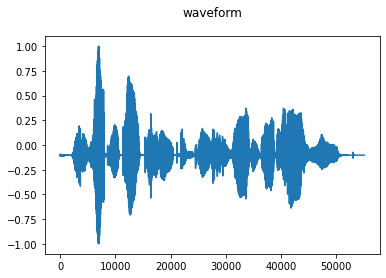

In [ ]:
plt.plot(waveform)
plt.title("waveform", pad=20)

torch.Size([201, 276])

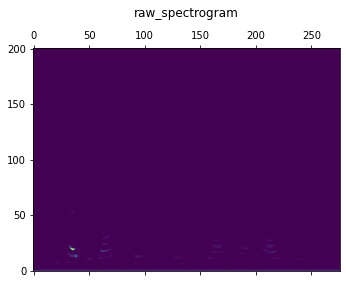

In [ ]:
plt.matshow(raw_spectrogram, origin='lower')
plt.title("raw_spectrogram", pad=20)
raw_spectrogram.shape

torch.Size([64, 276])

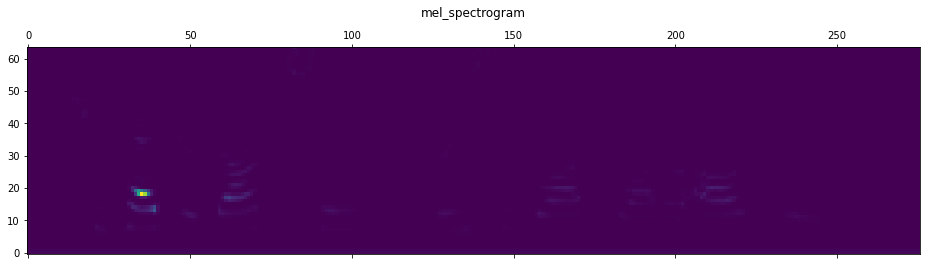

In [ ]:
plt.matshow(mel_spectrogram, origin='lower')
plt.title("mel_spectrogram", pad=20)
mel_spectrogram.shape

torch.Size([64, 276])

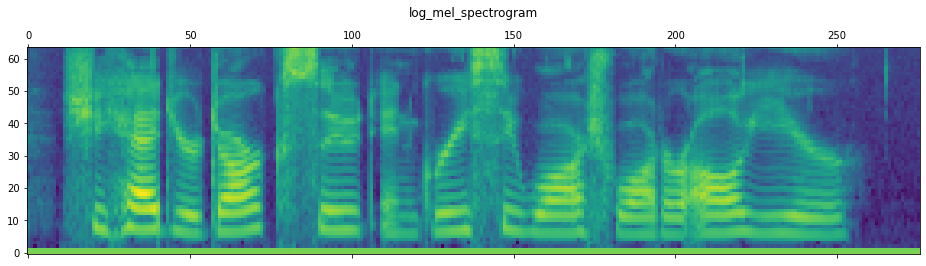

In [ ]:
plt.matshow(log_mel_spectrogram, origin='lower')
plt.title("log_mel_spectrogram", pad=20)
log_mel_spectrogram.shape

torch.Size([26, 276])

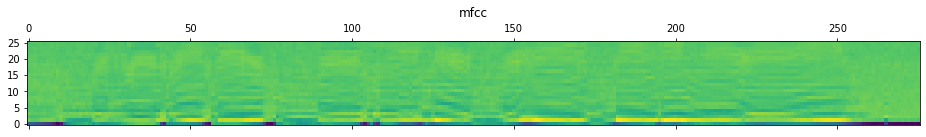

In [ ]:
plt.matshow(mfcc, origin='lower')
plt.title("mfcc", pad=20)
mfcc.shape

torch.Size([64, 276])

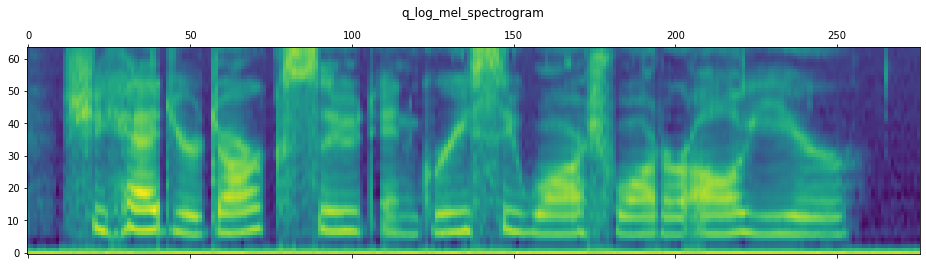

In [ ]:
plt.matshow(q_log_mel_spectrogram, origin='lower')
plt.title("q_log_mel_spectrogram", pad=20)
q_log_mel_spectrogram.shape

torch.Size([64, 276])

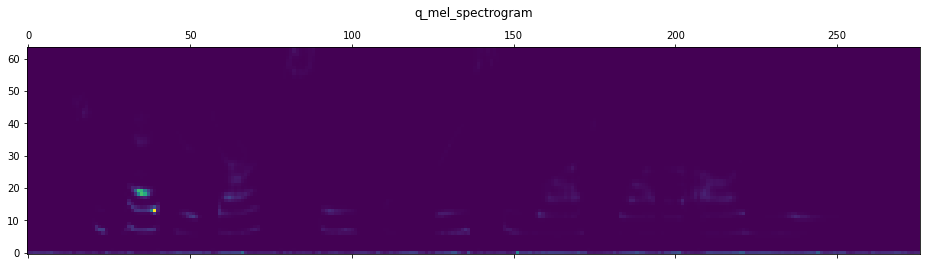

In [ ]:
plt.matshow(q_mel_spectrogram, origin='lower')
plt.title("q_mel_spectrogram", pad=20)
q_mel_spectrogram.shape

torch.Size([201, 276])

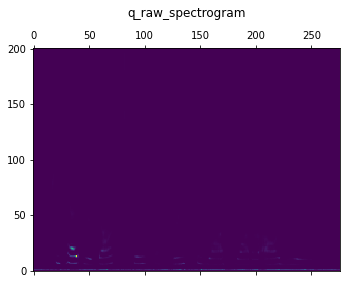

In [ ]:
plt.matshow(q_raw_spectrogram, origin='lower')
plt.title("q_raw_spectrogram", pad=20)
q_raw_spectrogram.shape

torch.Size([55092])

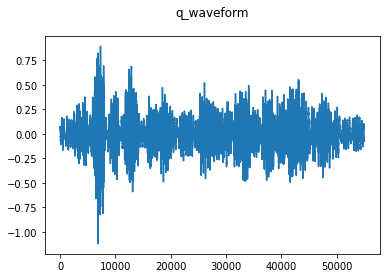

In [ ]:
plt.plot(q_waveform)
plt.title("q_waveform", pad=20)
waveform.shape

In [ ]:
import IPython

torchaudio.save("temp_raw.wav", waveform.unsqueeze(0), sample_rate=16000)
IPython.display.display(IPython.display.Audio("temp_raw.wav"))

In [ ]:
raw_spectrogram       = f_spectrogram(waveform)
mel_spectrogram       = f_melScale(raw_spectrogram)
log_mel_spectrogram   = f_log(mel_spectrogram)
mfcc                  = f_dct(log_mel_spectrogram)
q_log_mel_spectrogram = f_inv_dct(mfcc)
q_mel_spectrogram     = f_exp(q_log_mel_spectrogram)
q_raw_spectrogram     = f_inv_melScale(q_mel_spectrogram)
q_waveform            = f_griffinLim(q_raw_spectrogram)

torchaudio.save("mfcc_recon.wav", q_waveform.unsqueeze(0), sample_rate=16000)
IPython.display.display(IPython.display.Audio("mfcc_recon.wav"))

In [ ]:
raw_spectrogram       = f_spectrogram(waveform)
mel_spectrogram       = f_melScale(raw_spectrogram)
log_mel_spectrogram   = f_log(mel_spectrogram)
q_mel_spectrogram     = f_exp(log_mel_spectrogram)
q_raw_spectrogram     = f_inv_melScale(q_mel_spectrogram)
q_waveform            = f_griffinLim(q_raw_spectrogram)

torchaudio.save("log_mel_spec_recon.wav", q_waveform.unsqueeze(0), sample_rate=16000)
IPython.display.display(IPython.display.Audio("log_mel_spec_recon.wav"))

In [ ]:
raw_spectrogram       = f_spectrogram(waveform)
mel_spectrogram       = f_melScale(raw_spectrogram)
q_raw_spectrogram     = f_inv_melScale(mel_spectrogram)
q_waveform            = f_griffinLim(q_raw_spectrogram)

torchaudio.save("mel_spec_recon.wav", q_waveform.unsqueeze(0), sample_rate=16000)
IPython.display.display(IPython.display.Audio("mel_spec_recon.wav"))

In [ ]:
raw_spectrogram       = f_spectrogram(waveform)
q_waveform            = f_griffinLim(raw_spectrogram)

torchaudio.save("spec_recon.wav", q_waveform.unsqueeze(0), sample_rate=16000)
IPython.display.display(IPython.display.Audio("spec_recon.wav"))